In [ ]:
import dataclasses
import json
import pathlib
import threading
import time

import cv2
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import tqdm

import const
import utils

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
highway_excluded = list(pathlib.Path("../data/excluded/uzh").glob("*.npy"))
len(highway_excluded)  # 0

73

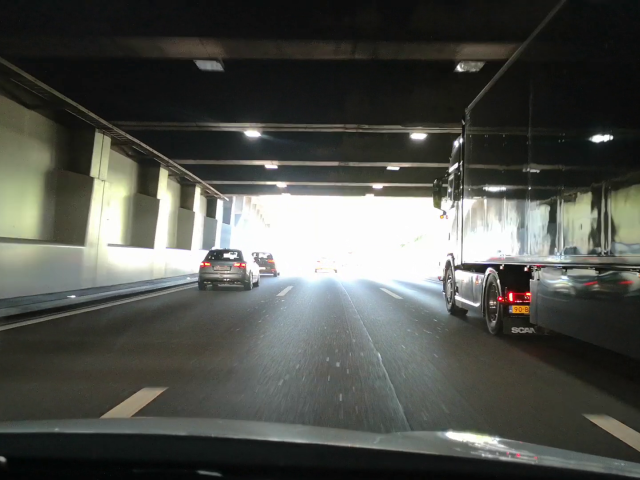

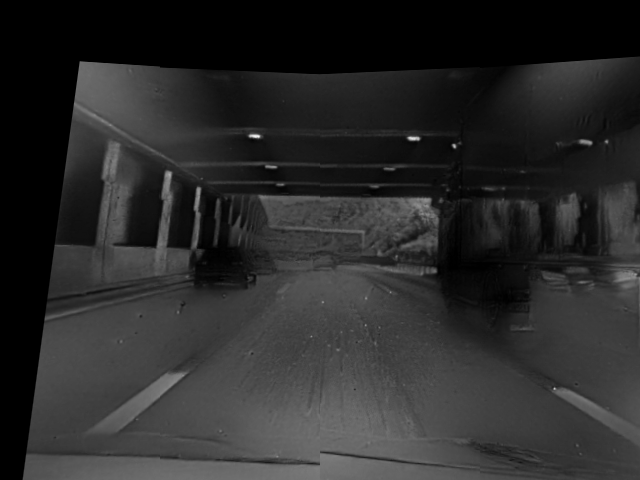

In [ ]:
bgrem = np.load(highway_excluded[50])
showarray(bgrem[:, :, :3])
showarray(bgrem[:, :, 3])

In [ ]:
WIDTH, HEIGHT = 640, 480

In [ ]:
import rpg_e2vid.utils.inference_utils as iu
import rpg_e2vid.utils.loading_utils as lu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lu.load_model(const.PRETRAINED_DIR / "E2VID_lightweight.pth.tar").to(device)
events = utils.EventsData.from_path("./parsed/highway1.bin")
_, ts_counts = np.unique(events.array[:, 0], return_counts=True)

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [ ]:
window_length = 50
event_it = utils.EventWindowIterator(
    events.array, ts_counts, window_length, stride=window_length
)
prev = None
rec_frames = []
event_frames = []
for window in tqdm.tqdm(event_it, total=len(event_it)):
    event_frame = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
    window_pos = window[window[:, -1] == 1].astype(int)
    window_neg = window[window[:, -1] == -1].astype(int)
    event_frame[window_pos[:, 2], window_pos[:, 1], 0] = 255
    event_frame[window_neg[:, 2], window_neg[:, 1], 2] = 255
    event_frames.append(event_frame)
    vg = iu.events_to_voxel_grid(window, 5, WIDTH, HEIGHT)
    vg = torch.from_numpy(vg).unsqueeze(0).float().to(const.DEVICE)
    with torch.no_grad():
        pred, prev = model(vg, prev)
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
        pred = cv2.undistort(pred, const.EVENT_MTX, const.EVENT_DIST)
        # sharpen
        pred_gb = cv2.GaussianBlur(pred, (0, 0), 3)
        pred = cv2.addWeighted(pred, 1.5, pred_gb, -0.5, 0)
        rec_frames.append(pred)

rec_frames = np.array(rec_frames)
event_frames = np.array(event_frames)

  0%|          | 0/2427 [00:00<?, ?it/s]

100%|██████████| 2427/2427 [04:51<00:00,  8.33it/s]


In [ ]:
window_length = 30
event_it = utils.EventWindowIterator(
    events.array, ts_counts, window_length, stride=window_length
)
event_frames = []
for window in tqdm.tqdm(event_it, total=len(event_it)):
    event_frame = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
    window_pos = window[window[:, -1] == 1].astype(int)
    window_neg = window[window[:, -1] == -1].astype(int)
    event_frame[window_pos[:, 2], window_pos[:, 1], 0] = 255
    event_frame[window_neg[:, 2], window_neg[:, 1], 2] = 255
    event_frames.append(event_frame)
event_frames = np.array(event_frames)

100%|██████████| 4045/4045 [00:29<00:00, 135.62it/s]


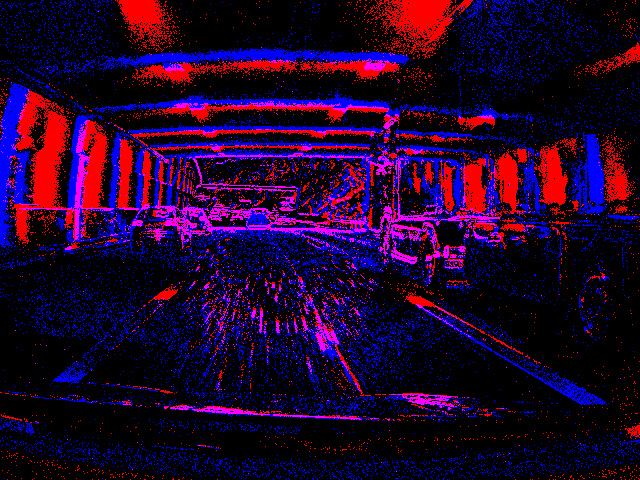

In [ ]:
showarray(event_frames[3260])

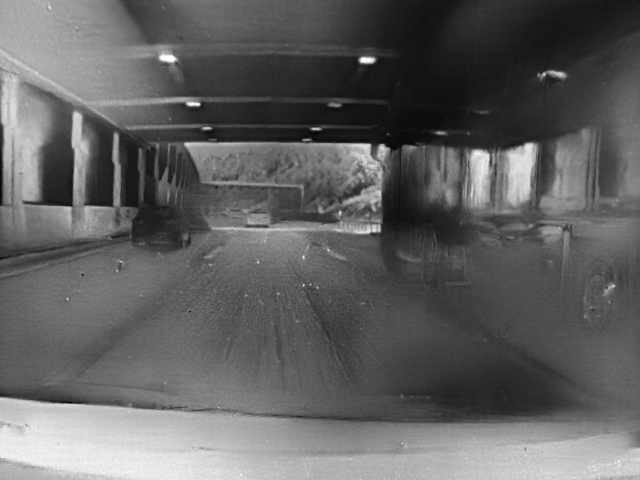

In [ ]:
showarray(rec_frames[1960])

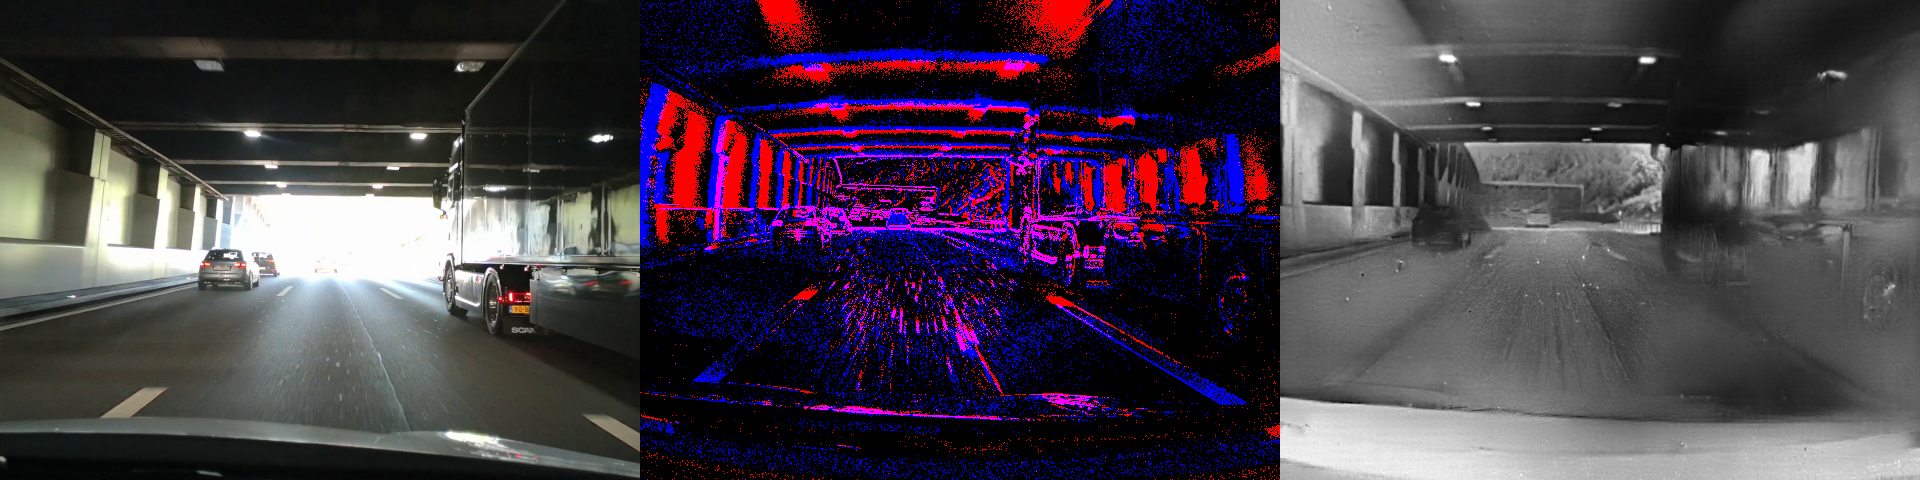

In [ ]:
rec_bgr = cv2.cvtColor(rec_frames[1960], cv2.COLOR_GRAY2BGR)
full_comp = np.concatenate([bgrem[:, :, :3], event_frames[3260], rec_bgr], axis=1)
showarray(full_comp)